In [2]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
from scipy.interpolate import make_interp_spline
from fastf1 import utils

# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [3]:
ses = 3
race = 18
session = fastf1.get_session(2023,race,ses)
session.load()
fastf1.Cache.enable_cache('cache') 

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\GTR\AppData\Local\Temp\fastf1.
	Size: 344.32 MB


core           INFO 	Loading data for United States Grand Prix - Sprint Shootout [v3.1.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '44', '4', '81', '55', '11', '63', '23', '10', '3', '14', '31', '18', '24', '27', '20', '7

### Pre defined

In [4]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

def calculate_delta_times(df_lap, df_reference):
    """Calculates the delta times for a given lap, relative to a reference lap.

    Args:
    lap_data: A numpy array containing the lap data. The lap data should be in the
        form of a 2D array, where the first column is the distance and the second
        column is the time.
    reference_lap_data: A numpy array containing the reference lap data. The
        reference lap data should be in the same format as the lap data.

    Returns:
    A numpy array containing the delta times.
    """
    # # Add attribute TimeS to the dataframe
    df_lap["TimeS"] = df_lap["Time"].dt.total_seconds()
    df_reference["TimeS"] = df_reference["Time"].dt.total_seconds()

    # # Stretch or contract the distances across all the data objects so that the total
    # # distance of the lap matches the fastest (reference) lap in the selection.
    df_lap["Distance"] = df_lap["Distance"] * (df_reference.iloc[-1]["Distance"] / df_lap.iloc[-1]["Distance"])
    # Use linear interpolation to align each data object with the data objects in
    # the fastest lap.

    interp_lap_data = np.interp(df_lap["Distance"], df_reference["Distance"],df_reference["TimeS"])
    # Return the difference in time at each instance.
    delta_times =  interp_lap_data.tolist() - df_lap["TimeS"]

    return delta_times, df_lap["Distance"]

def SectorDistance(laps):

    sector_time = []
    sector_distance = []
    lap = laps.pick_fastest()
    for i in range(3):
        sector_time.append(lap["Sector"+str(i+1)+"Time"])
    for i in range(2):
        sector_time[i+1] = sector_time[i] + sector_time[i+1]
    lap_telemetry = lap.get_telemetry()
    sector_distance.append(lap_telemetry.loc[lap_telemetry["Time"] <= sector_time[0],"Distance"].max())
    sector_distance.append(lap_telemetry.loc[lap_telemetry["Time"] <= sector_time[1],"Distance"].max())
    sector_distance.append(lap_telemetry["Distance"].max())
    return sector_distance
def SectorLocation(laps):

    sector_location = [[],[]]
    sector_distance = SectorDistance(laps)
    comp = laps.pick_fastest().get_telemetry()
    comp = comp [["X","Y","Distance"]]
    for i in sector_distance:
        Sec = comp
        Sec["MinDis"] = (Sec["Distance"] - i).abs()
        sec_loc = Sec.loc[Sec["MinDis"]==Sec["MinDis"].min(),["X","Y"]].values[0]
        sector_location[0].append(sec_loc[0]) # Append X
        sector_location[1].append(sec_loc[1]) # Append Y
    return sector_location

In [5]:
compound_color = {'HARD': 'F0F0EC', 
                  'INTERMEDIATE': '43B02A', 
                  'MEDIUM': 'FFD12E', 
                  'SOFT': 'DA291C', 
                  'TEST-UNKNOWN': '434649', 
                  'UNKNOWN': '00FFFF', 
                  'WET': '0067AD'}
compound = ['All Compounds','SOFT','MEDIUM','HARD']
df_compoundcolor = pd.DataFrame.from_dict(compound_color, orient='index', columns=['CompoundColor'])

In [6]:
# getting laps of session
laps = session.laps 

# adding lap time in seconds
laps['LapTimeS'] = laps["LapTime"].dt.total_seconds()
laps["LapTimeS"] = laps["LapTimeS"] - 60 # correcting lap time

# adding lap time start in seconds
laps['LapStartTimeS'] = laps["LapStartTime"].dt.total_seconds()

# adding lap time end in seconds
laps['DeltaTime'] = 0 # add column Delta time filled with 0

# getting max lap of session
max_lap = int(session.laps["LapNumber"].max())

#results of race
results = session.results

#correcting team color
results["TeamColor"] = [fastf1.plotting.team_color(i) for i in results["TeamName"]] 

# drivers list
drivers = session.drivers

# Drivers Start order 
drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start = drivers_start["DriverNumber"].values

#drivers abreviation
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

# Drivers Start order 
drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start_abr = drivers_start_abr["Abbreviation"].values

#race name 
race_name = session.event["EventName"]
session_name = session.event["Session"+str(ses)]
corners_distance = session.get_circuit_info().corners
sector_distance = SectorDistance(laps)
sector_location = SectorLocation(laps)

### Telemetry

In [7]:
### Version 2.0 telemetry plot

In [8]:
driver = ['1', '16', '44']
laps_driver = []
fastest_driver = []
telemetry_driver = []
team_driver = []
delta_time = []
max_delta_time = 0
for i in range(0,len(driver)):
    laps_driver.append(laps.pick_driver(driver[i]))
    fastest_driver.append(laps_driver[i].pick_fastest())
    telemetry_driver.append(fastest_driver[i].get_telemetry())
    team_driver.append(fastest_driver[i]['Team'])

for i in range(1,len(driver)):
    delta_time1, Distance  = calculate_delta_times(telemetry_driver[0], telemetry_driver[i])
    if (max_delta_time < delta_time1.max()):
        max_delta_time = delta_time1.max()
    delta_time.append(delta_time1)

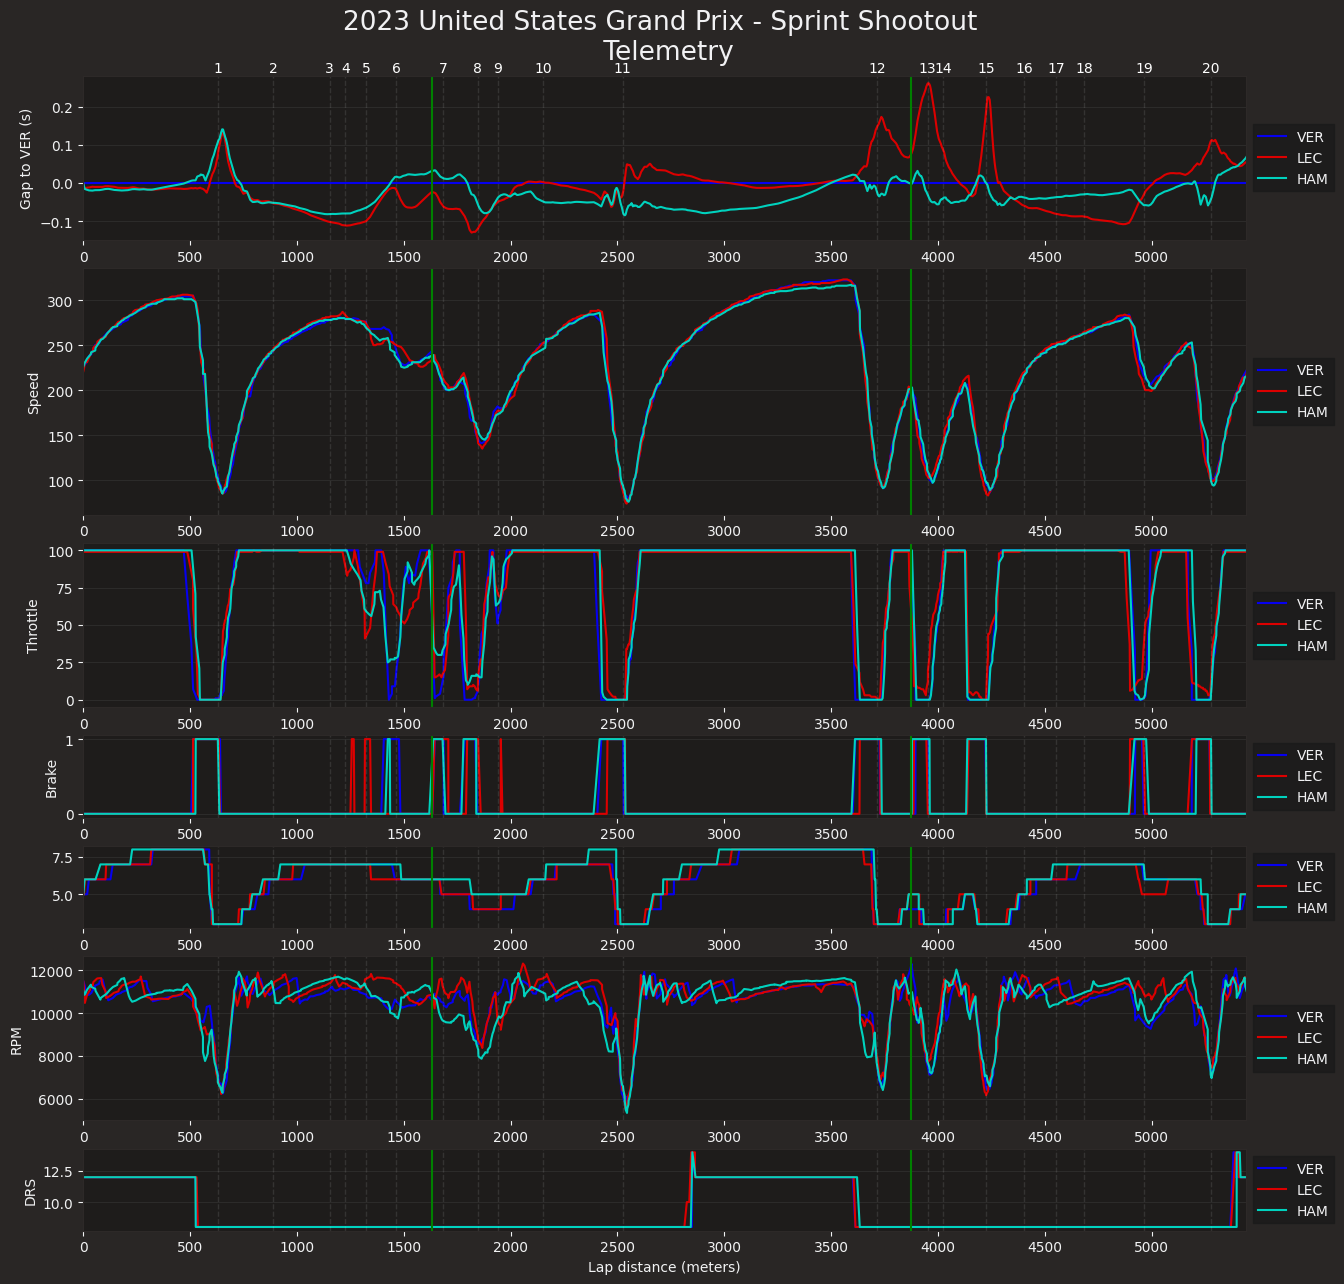

In [9]:

# plt.style.use("cyberpunk")
plot_size = [15, 15]
plot_title = f"{session.event.year} {session.event.EventName} - {session.name} \n Telemetry"
plot_ratios = [ 2, 3, 2, 1, 1, 2, 1]

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size

# Create subplots with different sizes
fig, ax = plt.subplots(7, gridspec_kw={'height_ratios': plot_ratios})

#Delta line
ax[0].axhline(0,label=session.get_driver(driver[0])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[0]))
# Delta time to first driver
for i in range(0,len(driver)-1):
    ax[0].plot(Distance, delta_time[i], label=session.get_driver(driver[i+1])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i+1]))
# ploting other graphes
for i in range(0,len(driver)):
    ax[1].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Speed'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[2].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Throttle'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[3].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['Brake'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[4].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['nGear'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[5].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['RPM'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))
    ax[6].plot(telemetry_driver[i]['Distance'], telemetry_driver[i]['DRS'], label=session.get_driver(driver[i])['Abbreviation'], color=fastf1.plotting.team_color(team_driver[i]))

# Set the plot title
ax[0].title.set_text(plot_title)
ax[0].set(ylabel=f"Gap to {session.get_driver(driver[0])['Abbreviation']} (s)")
ax[1].set(ylabel='Speed')
ax[1].legend(loc="lower right")
ax[2].set(ylabel='Throttle')
ax[3].set(ylabel='Brake')
ax[5].set(ylabel='RPM')
ax[6].set(ylabel='DRS')
ax[6].set(xlabel='Lap distance (meters)')


# Hide x labels and tick labels for top plots and y ticks for right plots.
# for a in ax.flat:
#     a.label_outer()
for i in range(0,7):
    ax[i].grid(axis = 'y',alpha = 0.1)
    ax[i].set_xticks(range(0, 8000, 500)) 
    ax[i].set_xlim(0, sector_distance[2]) 
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].axvline(x=sector_distance[0], color='green', linestyle='-')
    ax[i].axvline(x=sector_distance[1], color='green', linestyle='-')
    for j in range(0,len(corners_distance)):
        ax[i].axvline(x=corners_distance['Distance'][j], color='white', linestyle='--', linewidth=1, alpha=0.1)

highest_y_value = ax[0].get_ylim()[1]
for j in range(0,len(corners_distance)):
    ax[0].text(corners_distance['Distance'][j],highest_y_value+0.02,str(j+1), ha='center', va='center',color='white')
    
# Store figure
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/Telemetry'+session.event["Session"+str(ses)]+'.png', dpi=300, bbox_inches='tight')
plt.show()

### Speed map 

In [10]:
driverss = [1,16]

laps = session.laps
# Select the laps from Hamilton and Verstappen
laps_driver1 = laps.pick_driver(driverss[0])
laps_driver2 = laps.pick_driver(driverss[1])

# Get the telemetry data from their fastest lap
fastest_driver1 = laps_driver1.pick_fastest().get_telemetry()
fastest_driver2 = laps_driver2.pick_fastest().get_telemetry()
# Since the telemetry data does not have a variable that indicates the driver, 
# we need to create that column
fastest_driver1['Driver'] = session.get_driver(str(driverss[0]))["Abbreviation"]
fastest_driver2['Driver'] = session.get_driver(str(driverss[1]))["Abbreviation"]

# Merge both lap telemetries so we have everything in one DataFrame
telemetry = fastest_driver1.append(fastest_driver2)

# We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = telemetry['Distance'].max()

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors
# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

# Calculate avg. speed per driver per mini sector
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

# Join the fastest driver per minisector with the full telemetry
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == session.get_driver(str(driverss[0]))["Abbreviation"], 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == session.get_driver(str(driverss[1]))["Abbreviation"], 'Fastest_driver_int'] = 2

C:\Users\GTR\AppData\Local\Temp\ipykernel_3316\781291173.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = fastest_driver1.append(fastest_driver2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


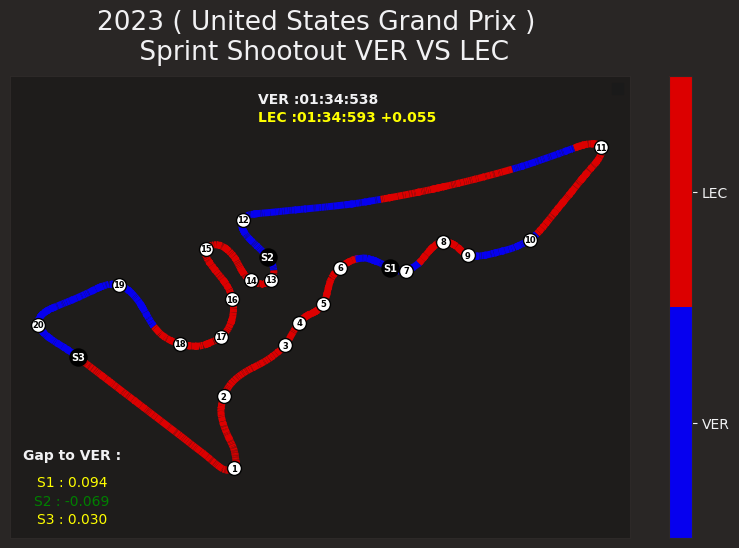

In [11]:
lap_time =[]
for i in driverss:
    timedelta = laps.pick_driver(i).pick_fastest()['LapTime']
    # Extract minutes, seconds, and milliseconds
    minutes = timedelta.components.minutes
    seconds = timedelta.components.seconds
    milliseconds = timedelta.components.milliseconds

    # Format the result as mm:ss:ms
    formatted_time = f'{minutes:02}:{seconds:02}:{milliseconds:03}'
    lap_time.append(formatted_time)


driver1 = laps.pick_driver(driverss[0]).pick_fastest()[["Sector1Time","Sector2Time" ,"Sector3Time"]]
driver1["S1"] = driver1["Sector1Time"].total_seconds()
driver1["S2"] = driver1["Sector2Time"].total_seconds()
driver1["S3"] = driver1["Sector3Time"].total_seconds()
driver2 = laps.pick_driver(driverss[1]).pick_fastest()[["Sector1Time","Sector2Time" ,"Sector3Time"]]
driver2["S1"] = driver2["Sector1Time"].total_seconds()
driver2["S2"] = driver2["Sector2Time"].total_seconds()
driver2["S3"] = driver2["Sector3Time"].total_seconds()
comparaison = driver2[["S1","S2","S3"]].reset_index(drop=True) - driver1[["S1","S2","S3"]].reset_index(drop=True)

sector_color = []
for i in comparaison:
    if (i < 0):
        sector_color.append("green")
    else:
        sector_color.append("yellow")

x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

custom_colors = [fastf1.plotting.team_color(session.get_driver(str(driverss[0]))["TeamName"]), fastf1.plotting.team_color(session.get_driver(str(driverss[1]))["TeamName"])]
cmap = cm.colors.ListedColormap(custom_colors)

# cmap = cm.get_cmap(["blue","red"], 2)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [10, 6]
fig, ax = plt.subplots()

# Hide both x and y-axis
ax.set_xticks([])
ax.set_yticks([])

plt.gca().add_collection(lc_comp)
plt.axis('equal')

# plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
cbar.set_ticks(np.arange(1.5, 3))
cbar.set_ticklabels([session.get_driver(str(driverss[0]))["Abbreviation"], session.get_driver(str(driverss[1]))["Abbreviation"]])

plt.scatter(corners_distance['X'], corners_distance['Y'], color='white', s=100, zorder=2 , edgecolors='black')
plt.scatter(sector_location[0], sector_location[1], color='Black', s=150, zorder=2 , edgecolors='black')

for i in range(0,len(corners_distance)):
    plt.text(corners_distance['X'][i],corners_distance['Y'][i],str(i+1), ha='center', va='center',color='black', fontsize=6, fontweight='bold')
for i in range(0,len(sector_location)+1):
    plt.text(sector_location[0][i],sector_location[1][i],"S"+str(i+1), ha='center', va='center',color='white', fontsize=7, fontweight='bold')

plt.title('2023 ( '+session.event["EventName"]+' ) \n '+session_name+' '+session.get_driver(str(driverss[0]))["Abbreviation"]+' VS '+session.get_driver(str(driverss[1]))["Abbreviation"])
plt.legend()
# plt.axis('off')
plt.text(0.4, 0.95, session.get_driver(str(driverss[0]))["Abbreviation"]+' :'+lap_time[0]+'', ha='left', va='center', transform=ax.transAxes, fontweight = 'bold')
plt.text(0.4, 0.91, session.get_driver(str(driverss[1]))["Abbreviation"]+' :'+lap_time[1] +' +'+"{:.3f}".format(comparaison.sum()), ha='left', va='center', transform=ax.transAxes, fontweight = 'bold',color ='yellow')

# Sectors
plt.text(0.1, 0.18, 'Gap to '+session.get_driver(str(driverss[0]))["Abbreviation"]+' :', ha='center', va='center', transform=ax.transAxes, fontweight = 'bold')
plt.text(0.1, 0.12, 'S1 : '+"{:.3f}".format(comparaison[0]), ha='center', va='center', transform=ax.transAxes, color = sector_color[0])
plt.text(0.1, 0.08, 'S2 : '+"{:.3f}".format(comparaison[1]), ha='center', va='center', transform=ax.transAxes,color = sector_color[1])
plt.text(0.1, 0.04, 'S3 : '+"{:.3f}".format(comparaison[2]), ha='center', va='center', transform=ax.transAxes,color = sector_color[2])
# plt.savefig(f"2021_ver_ham_q.png", dpi=300)

plt.show()